# Vaccinatie-/Misinformatie-Classifier
## ...

(hier komt wat uitleg waar dit over gaat en wat het is).


In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from math import log, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import numpy as np
import glob
import os
from collections import Counter
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from string import punctuation
import eli5

STOPWORDS = get_stop_words('dutch')

### 1. Define functions for preprocessing and data retrieval

In [3]:
def preprocess(doc):
    if type(doc) is str:
        doc = doc.lower()
        doc = doc.translate(str.maketrans({key: " " for key in string.punctuation}))
        doc = " ".join([w for w in doc.split() if w not in STOPWORDS])
        return doc
    else:
        print('Received non-string input, returning empty string')
        return ''

In [4]:
def get_traintest(df, test_size=.30):
    '''takes dataframe, selects relevant part, preprocesses text and returns train, test data lists with 
    (text, label) tuples'''
    rows = df[['Platte tekst (zonder opmaak)','Misinfo Nee(1) Ja(0)']].dropna().to_records(index=False)
    rowsclean = []
    for e in rows:
        try:
            rowsclean.append((preprocess(e[0]), abs(int(e[1])-1)))  # we now code misinfo as 1 and legitimate as 0
        except ValueError:
            pass
    if test_size < 1:
        train, test = train_test_split(rowsclean, test_size=test_size)
        return train, test
    if test_size == 1:
        return [], rowsclean


### 2. Read data

We have two datasets: one on childhood vaccination on which we train and test, and one on HPV that we use for testing out-of-sample prediction only

In [5]:
hpv = pd.read_csv('hpv.csv')
childhood = pd.read_csv('childhood.csv')

In [6]:
childhood_train, childhood_test = get_traintest(childhood)
print("Obtained {} train and {} test tuples for childhood vaccination".format(len(childhood_train), len(childhood_test)))

hpv_train, hpv_test = get_traintest(hpv, test_size=1)
print("Obtained {} train and {} test tuples for HPV".format(len(hpv_train), len(hpv_test)))

Obtained 316 train and 136 test tuples for childhood vaccination
Obtained 0 train and 198 test tuples for HPV


### 3. Define Machine Learning-functions

In [7]:
def performance(predictions, actual_scores):
    accuracy=metrics.accuracy_score(actual_scores,predictions,normalize=True)
    recall_misinfo=metrics.recall_score(actual_scores,predictions,pos_label=1)
    recall_legitimate=metrics.recall_score(actual_scores,predictions,pos_label=0)
    precision_misinfo=metrics.precision_score(actual_scores,predictions,pos_label=1)
    precision_legitimate=metrics.precision_score(actual_scores,predictions,pos_label=0)
    confusionmatrix=metrics.confusion_matrix(actual_scores,predictions)
    print('Accuracy:',accuracy,
          '\nRecall (misinfo):',recall_misinfo,
          '\nPrecision (misinfo):',precision_misinfo,
          '\nRecall (legitimate):',recall_legitimate,
          '\nPrecision (legitimate) ',precision_legitimate,
          '\nConfusion Matrix:','\n',confusionmatrix)


In [8]:
def roc_curve(predicted_probabilities, actual_scores):
    fpr, tpr, thresholds = metrics.roc_curve(actual_scores, predicted_probabilities[:,1],pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC AUC:\n{}".format(roc_auc))
    #%%
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [9]:
def get_optimal_threshold(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]    # return threshold score of the last (i.e., highest j_score)_ot

### Naive Bayes (count)

Accuracy: 0.9191176470588235 
Recall (misinfo): 0.9361702127659575 
Precision (misinfo): 0.8461538461538461 
Recall (legitimate): 0.9101123595505618 
Precision (legitimate)  0.9642857142857143 
Confusion Matrix: 
 [[81  8]
 [ 3 44]]
ROC AUC:
0.9671288548888357


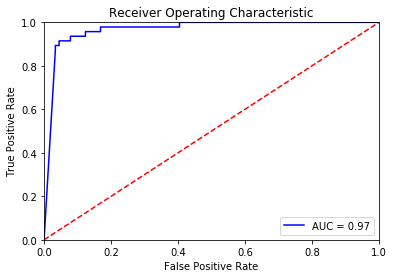

In [10]:
vec = CountVectorizer()
clf = MultinomialNB()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

### Naive Bayes (tfidf)

Accuracy: 0.8823529411764706 
Recall (misinfo): 0.6808510638297872 
Precision (misinfo): 0.9696969696969697 
Recall (legitimate): 0.9887640449438202 
Precision (legitimate)  0.8543689320388349 
Confusion Matrix: 
 [[88  1]
 [15 32]]
ROC AUC:
0.9662921348314606


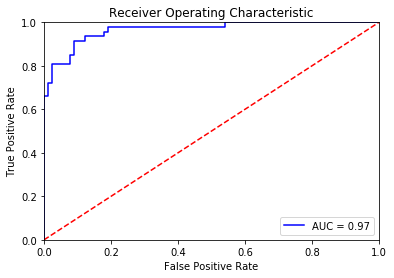

In [11]:
vec = TfidfVectorizer()
clf = MultinomialNB()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

### Logistic Regression (count)

/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.9117647058823529 
Recall (misinfo): 0.8723404255319149 
Precision (misinfo): 0.8723404255319149 
Recall (legitimate): 0.9325842696629213 
Precision (legitimate)  0.9325842696629213 
Confusion Matrix: 
 [[83  6]
 [ 6 41]]
ROC AUC:
0.9662921348314608


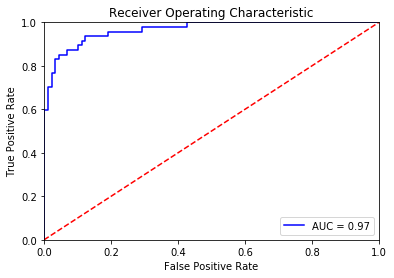

In [12]:
vec = CountVectorizer()
clf = LogisticRegression()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

### Logistic Regression (tfidf)

/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.9485294117647058 
Recall (misinfo): 0.8936170212765957 
Precision (misinfo): 0.9545454545454546 
Recall (legitimate): 0.9775280898876404 
Precision (legitimate)  0.9456521739130435 
Confusion Matrix: 
 [[87  2]
 [ 5 42]]
ROC AUC:
0.9775280898876404


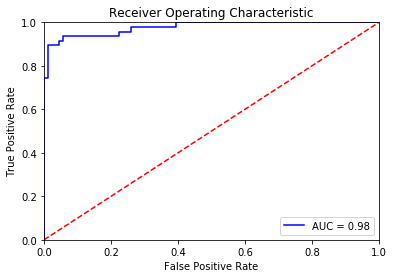

In [13]:
vec = TfidfVectorizer()
clf = LogisticRegression()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

### Logistic Regression (tfidf) with optimized cutoff point
(Spoiler: doesn't really change things)

In [14]:
fpr,tpr, thresholds = metrics.roc_curve([r[1] for r in childhood_test], predicted_probabilities[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
print("ROC AUC: {}".format(roc_auc))

optimal_threshold = get_optimal_threshold(fpr,tpr,thresholds)
print(optimal_threshold, np.exp(optimal_threshold))

predictions_new = np.where(predicted_probabilities[:,1] > optimal_threshold, 1, 0)

print('\n\nWITH THRESHOLD OF {}'.format(np.exp(optimal_threshold)))
performance(predictions_new, [e[1] for e in childhood_test])

ROC AUC: 0.9775280898876404
0.5035916572512293 1.6546535594039542


WITH THRESHOLD OF 1.6546535594039542
Accuracy: 0.9485294117647058 
Recall (misinfo): 0.8723404255319149 
Precision (misinfo): 0.9761904761904762 
Recall (legitimate): 0.9887640449438202 
Precision (legitimate)  0.9361702127659575 
Confusion Matrix: 
 [[88  1]
 [ 6 41]]


.... this doesn't really change anything.

## Feature Weights

Here, we use `eli5` to get a better idea of the features

In [15]:
eli5.show_weights(pipe,top=20)

Weight?,Feature
+0.965,we
+0.951,immuunsysteem
+0.850,dr
+0.723,onze
+0.713,stoffen
+0.702,vaccinatieschade
+0.699,onderzoek
+0.657,bijsluiter
+0.633,vaccin
+0.609,http


In [16]:
eli5.show_prediction(clf, hpv_test[2][0],vec=vec)

## Out of sample prediction

Accuracy: 0.8181818181818182 
Recall (misinfo): 0.5151515151515151 
Precision (misinfo): 0.8947368421052632 
Recall (legitimate): 0.9696969696969697 
Precision (legitimate)  0.8 
Confusion Matrix: 
 [[128   4]
 [ 32  34]]
ROC AUC:
0.8859044995408631


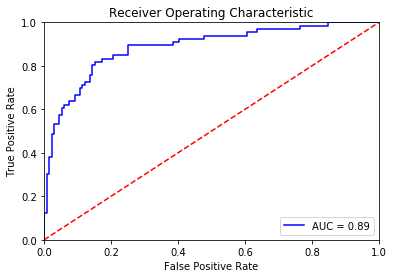

In [17]:

oos_predictions = pipe.predict([r[0] for r in hpv_test])
oos_predicted_probabilities = pipe.predict_proba([r[0] for r in hpv_test])


performance(oos_predictions, [e[1] for e in hpv_test])
roc_curve(oos_predicted_probabilities, [e[1] for e in hpv_test])

... but maybe here it's actually better if we used the adapted probabilities

In [18]:
oos_predictions_new = np.where(oos_predicted_probabilities[:,1] > optimal_threshold, 1, 0)

print('\n\nWITH THRESHOLD OF {}'.format(np.exp(optimal_threshold)))
performance(oos_predictions_new, [e[1] for e in hpv_test])



WITH THRESHOLD OF 1.6546535594039542
Accuracy: 0.8131313131313131 
Recall (misinfo): 0.5 
Precision (misinfo): 0.8918918918918919 
Recall (legitimate): 0.9696969696969697 
Precision (legitimate)  0.7950310559006211 
Confusion Matrix: 
 [[128   4]
 [ 33  33]]
